In [5]:
%matplotlib inline

In [6]:
import numpy
from numpy import dot, eye, ones, zeros
import scipy.linalg
from kernel_icd import kernel_icd
from kernels import LinearKernel

class KCCA(object):
    """An implementation of Kernel Canonical Correlation Analysis.

    """
    def __init__(self, kernel1, kernel2, regularization, method = 'kettering_method',
                 decomp = 'full', lrank = None,
                 scaler1 = None,
                 scaler2 = None,
                 max_variance_ratio = 1.0):

        if decomp not in ('full', 'icd'): #error handling
            raise ValueError("Error: valid decom values are full or icd, received: "+str(decomp))
            
        #initializing values inputted to class
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.reg = regularization
        self.method = getattr(self, decomp + "_" + method)
            #getattr() returns value of named attribute
            #equivalent to self.method = self.decomp+'_'+self.method

        self.decomp = decomp
        self.lrank = lrank

        self.alpha1 = None
        self.alpha2 = None
        self.trainX1 = None
        self.trainX2 = None
        self.max_variance_rato = max_variance_ratio

        if scaler1 is not None:
            if hasattr(scaler1, "transform"):  #sklearn scaler
                # hasattr returns true/false if variable has an attribute
                self.scaler1 = scaler1.transform
            else:  #assume callable function
                self.scaler1 = scaler1
        else:
            self.scaler1 = None

        if scaler2 is not None:
            if hasattr(scaler2, "transform"):  #sklearn scaler
                self.scaler2 = scaler2.transform
            else:  #assume callable function
                self.scaler2 = scaler2
        else:
            self.scaler2 = None

    def full_standard_hardoon_method(self, K1, K2, reg):

        N = K1.shape[0]
        I = eye(N)
        Z = numpy.zeros((N,N))

        R1 = numpy.c_[Z, dot(K1, K2)]
        R2 = numpy.c_[dot(K2, K1), Z]
        R =  numpy.r_[R1, R2]

        D1 = numpy.c_[dot(K1, K1 + reg*I), Z]
        D2 = numpy.c_[Z, dot(K2, K2 + reg*I)]
        D = 0.5*numpy.r_[D1, D2]

        return (R, D)

    def full_simplified_hardoon_method(self, K1, K2, reg):

        N = K1.shape[0]
        I = eye(N)
        Z = numpy.zeros((N,N))

        R1 = numpy.c_[Z, K2]
        R2 = numpy.c_[K1, Z]
        R =  numpy.r_[R1, R2]

        D1 = numpy.c_[K1 + reg*I, Z]
        D2 = numpy.c_[Z, K2 + reg*I]
        D = numpy.r_[D1, D2]

        return (R, D)

    def full_kettering_method(self, K1, K2, reg):

        N = K1.shape[0]
        I = eye(N)
        Z = numpy.zeros((N,N))

        R1 = numpy.c_[K1, K2]
        R2 = R1
        R = 1./2 * numpy.r_[R1, R2]

        D1 = numpy.c_[K1 + reg*I, Z]
        D2 = numpy.c_[Z, K2 + reg*I]
        D = numpy.r_[D1, D2]

        return (R, D)

    #def kcca(self, K1, K2):

        ##remove the mean in features space
        #N = K1.shape[0]
        #N0 = eye(N) - 1./N * ones(N)

        #if self.scaler1 is None:
            #K1 = dot(dot(N0,K1),N0)
        #if self.scaler2 is None:
            #K2 = dot(dot(N0,K2),N0)

        #R, D = self.method(K1, K2, self.reg)

        ##solve generalized eigenvalues problem
        #betas, alphas = scipy.linalg.eig(R,D)
        #ind = numpy.argsort(numpy.real(betas))
        #max_ind = ind[-1]
        #alpha = alphas[:, max_ind]
        #alpha = alpha/numpy.linalg.norm(alpha)
        #beta = numpy.real(betas[max_ind])

        #alpha1 = alpha[:N]
        #alpha2 = alpha[N:]

        #y1 = dot(K1, alpha1)
        #y2 = dot(K2, alpha2)

        #self.alpha1 = alpha1
        #self.alpha2 = alpha2

        #return (y1, y2, beta)
        
    #******* .fit calls kcca ********************
    def kcca(self, K1, K2):
        #K1 and K2 are the two linearkernels of the two dataviews

        #remove the mean in features space
        N = K1.shape[0]
        N0 = eye(N) - 1./N * ones(N) #./ ensures division yields a float
        
        #scaler1 and scaler2 hold the datasets
        if self.scaler1 is None:
            K1 = dot(dot(N0,K1),N0)
        if self.scaler2 is None:
            K2 = dot(dot(N0,K2),N0)

        R, D = self.method(K1, K2, self.reg) #calls one of the functions above

        #solve generalized eigenvalues problem
        betas, alphas = scipy.linalg.eig(R,D)

        #sorting according to eigenvalue
        betas =  numpy.real(betas)
        ind = numpy.argsort(betas)
        betas = betas[ind]
        betas = betas[::-1]

        #finding the components
        if self.max_variance_rato < 1.0:
            n_samples = len(betas)
            explained_variance = (betas ** 2) / n_samples
            explained_variance_ratio = explained_variance / explained_variance.sum()
            ratio_cumsum = explained_variance_ratio.cumsum()
            n_components = numpy.sum(ratio_cumsum < self.max_variance_rato) + 1
        else:
            #using all the dimensions
            n_components = len(betas)
            
        alphas = alphas[:, ind]
        alpha = alphas[:, :n_components]

        #alpha = alpha/numpy.linalg.norm(alpha)
        #making unit vectors
        alpha = alpha / (numpy.sum(numpy.abs(alpha)**2 ,axis=0)**(1./2))

        alpha1 = alpha[:N, :]
        alpha2 = alpha[N:, :]

        y1 = dot(K1, alpha1)
        y2 = dot(K2, alpha2)

        self.alpha1 = alpha1
        self.alpha2 = alpha2

        return (y1, y2, betas[0])

    def icd_simplified_hardoon_method(self, G1, G2, reg):
        N1 = G1.shape[1]
        N2 = G2.shape[1]

        Z11 = zeros((N1, N1))
        Z22 = zeros((N2, N2))
        Z12 = zeros((N1,N2))

        I11 = eye(N1)
        I22 = eye(N2)

        R1 = numpy.c_[Z11, dot(G1.T, G2)]
        R2 = numpy.c_[dot(G2.T, G1), Z22]
        R =  numpy.r_[R1, R2]

        D1 = numpy.c_[dot(G1.T, G1) + reg*I11, Z12]
        D2 = numpy.c_[Z12.T, dot(G2.T, G2) + reg*I22]
        D = numpy.r_[D1, D2]

        return (R, D)

    def icd(self, G1, G2):
        """Incomplete Cholesky decomposition
        """

        # remove mean. avoid standard calculation N0 = eye(N)-1/N*ones(N);
        G1 = G1 - numpy.array(numpy.mean(G1, 0), ndmin=2, copy=False)
        G2 = G2 - numpy.array(numpy.mean(G2, 0), ndmin=2, copy=False)

        R, D = self.method(G1, G2, self.reg)

        #solve generalized eigenvalues problem
        betas, alphas = scipy.linalg.eig(R,D)
        ind = numpy.argsort(numpy.real(betas))
        max_ind = ind[-1]
        alpha = alphas[:, max_ind]
        alpha = alpha/numpy.linalg.norm(alpha)
        beta = numpy.real(betas[max_ind])

        N1 = G1.shape[1]
        alpha1 = alpha[:N1]
        alpha2 = alpha[N1:]

        y1 = dot(G1, alpha1)
        y2 = dot(G2, alpha2)

        self.alpha1 = alpha1
        self.alpha2 = alpha2

        return (y1, y2, beta)

    #************ this is the function that will likely be called the most *********************
    def fit(self, X1, X2):

        if self.scaler1 is not None:
            X1 = self.scaler1(X1) #scaler1 is a lambda function that copies the input
        if self.scaler2 is not None:
            X2 = self.scaler2(X2) #scaler2 does the same thing as scaler1
        
        #initialize training sets
        self.trainX1 = X1
        self.trainX2 = X2

        if self.decomp == "full":
            self.K1 = self.kernel1(X1, X1) #kernel1 is the linearkernel class
            self.K2 = self.kernel2(X2, X2) #kernel2 is the linearkernel class
            (y1, y2, beta) = self.kcca(self.K1, self.K2) #kcca function is called
        else:
            # get incompletely decomposed kernel matrices. K \approx G*G'
            self.K1 = kernel_icd(X1, self.kernel1,  self.lrank)
            self.K2 = kernel_icd(X2, self.kernel2,  self.lrank)
            (y1, y2, beta) = self.icd(self.K1, self.K2) #icd function is called

        self.y1_ = y1
        self.y2_ = y2
        self.beta_ = beta
        return self

    def transform(self, X1 = None, X2 = None):
        """

        Features centering taken from:
        Scholkopf, B., Smola, A., & Muller, K. R. (1998).
        Nonlinear component analysis as a kernel eigenvalue problem.
        Neural computation, 10(5), 1299-1319.
        """
        
        rets = []
        if X1 is not None:

            if self.scaler1 is not None:
                X1 = self.scaler1(X1)

            Ktest = self.kernel1(X1, self.trainX1)
            K = self.K1

            if self.scaler1 is None:
                L, M = Ktest.shape
                ones_m = ones((M, M))
                ones_mp = ones((L, M)) / M

                #features centering
                K1 = (Ktest - dot(ones_mp, K)
                      - dot(Ktest, ones_m) + dot(dot(ones_mp, K), ones_m)
                      )
            else:
                K1 = Ktest

            res1 =  dot(K1, self.alpha1)
            rets.append(res1)

        if X2 is not None:

            if self.scaler2 is not None:
                X2 = self.scaler2(X2)

            Ktest = self.kernel2(X2, self.trainX2)
            K = self.K2

            if self.scaler2 is None:
                L, M = Ktest.shape
                ones_m = ones((M, M))
                ones_mp = ones((L, M)) / M

                #features centering
                K2 = (Ktest - dot(ones_mp, K)
                      - dot(Ktest, ones_m) + dot(dot(ones_mp, K), ones_m)
                      )
            else:
                K2 = Ktest

            res2 =  dot(K2, self.alpha2)
            rets.append(res2)

        return rets

def _mean_and_std(X, axis=0, with_mean=True, with_std=True):
    """Compute mean and std dev for centering, scaling

    Zero valued std components are reset to 1.0 to avoid NaNs when scaling.
    """
    X = numpy.asarray(X)
    Xr = numpy.rollaxis(X, axis)

    if with_mean:
        mean_ = Xr.mean(axis=0)
    else:
        mean_ = None

    if with_std:
        std_ = Xr.std(axis=0)
        if isinstance(std_, numpy.ndarray):
            std_[std_ == 0.0] = 1.0
        elif std_ == 0.:
            std_ = 1.
    else:
        std_ = None

    return mean_, std_

class UnscaledKCCA(KCCA):
    def __init__(self, kernel1, kernel2, regularization,
                 method = 'kettering_method',
                 max_variance_ratio = 1.0,
                 ) :
        super(UnscaledKCCA, self).__init__(kernel1, kernel2, regularization,
                 method,
                 'full', None,
                 None,
                 None,
                 max_variance_ratio)

        #this is to avoid pickling problems
        self.method = method

    def kcca(self, K1, K2):

        method = getattr(self, "full_" + self.method)
        R, D = method(K1, K2, self.reg)

        #solve generalized eigenvalues problem
        betas, alphas = scipy.linalg.eig(R,D)

        #sorting according to eigenvalue
        betas =  numpy.real(betas)
        ind = numpy.argsort(betas)
        betas = betas[ind]
        betas = betas[::-1]

        #fiding the components
        n_samples = len(betas)
        if self.max_variance_rato < 1.0:
            explained_variance = (betas ** 2) / n_samples
            explained_variance_ratio = explained_variance / explained_variance.sum()
            ratio_cumsum = explained_variance_ratio.cumsum()
            n_components = numpy.sum(ratio_cumsum < self.max_variance_rato) + 1
        else:
            #using all the dimensions
            n_components = n_samples

        alphas = alphas[:, ind]
        alpha = alphas[:, :n_components]

        #alpha = alpha/numpy.linalg.norm(alpha)
        #making unit vectors
        alpha = alpha / (numpy.sum(numpy.abs(alpha)**2 ,axis=0)**(1./2))

        N = K1.shape[0]
        alpha1 = alpha[:N, :] #up to shape of K1
        alpha2 = alpha[N:, :] #remainder of alpha

        y1 = dot(K1, alpha1)
        y2 = dot(K2, alpha2)

        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.y1_ = y1 #dot product of K1 and alpha1
        self.y2_ = y2
        self.beta_ = betas[0]
        self.betas_ = betas

        return (y1, y2, betas[0])

    def fit(self, X1, X2, K1_args = None, K2_args=None):
        self.trainX1 = X1
        self.trainX2 = X2

        if K1_args is not None:
            self.K1 = self.kernel1(X1, X1, K1_args)
        else:
            self.K1 = self.kernel1(X1, X1)
        if K2_args is not None:
            self.K2 = self.kernel2(X2, X2, K2_args)
        else:
            self.K2 = self.kernel2(X2, X2)
        (y1, y2, beta) = self.kcca(self.K1, self.K2)

        self.y1_ = y1
        self.y2_ = y2
        self.beta_ = beta
        return self

    def transform(self, X1 = None, X2 = None,
                  n_dims_frac = 0.1,
                  K1_args = None,
                  K2_args = None,):
        """
        """
        rets = []
        if X1 is not None:
            if type(n_dims_frac) is float:
                n_dims = numpy.ceil(n_dims_frac * self.alpha1.shape[1])
            else:
                n_dims = n_dims_frac
            if K1_args is not None:
                Ktest = self.kernel1(X1, self.trainX1, K1_args)
            else:
                Ktest = self.kernel1(X1, self.trainX1)

            res1 =  dot(Ktest, self.alpha1[:, :n_dims])
            rets.append(res1)

        if X2 is not None:
            if type(n_dims_frac) is float:
                n_dims = numpy.ceil(n_dims_frac * self.alpha2.shape[1])
            else:
                n_dims = n_dims_frac
            if K2_args is not None:
                Ktest = self.kernel2(X2, self.trainX2, K2_args)
            else:
                Ktest = self.kernel2(X2, self.trainX2)
            K2 = self.K2

            res2 =  dot(Ktest, self.alpha2[:, :n_dims])
            rets.append(res2)

        return rets


Done  0.9999999911541163
Trying to test
True
True


/Users/theodorelee/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


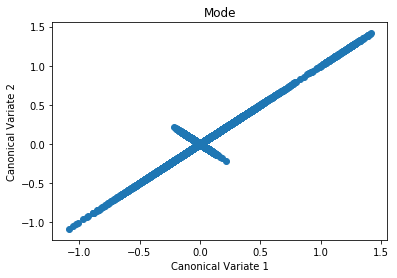

In [7]:
x1 = numpy.random.rand(200, 100) #100 x 20 matrix with rand values between 0 and 1
x2 = numpy.random.rand(200, 150) #100 x 30 matrix with rand values between 0 and 1
kernel = LinearKernel() #initialize a linear kernel class
cca = KCCA(kernel, kernel,
                regularization=1e-5,
                decomp='full',
                method='kettering_method',
                scaler1=lambda x:x,
                scaler2=lambda x:x).fit(x1,x2)
#fitting finds the optimal canonical vectors to maximize the correlation of variates

print("Done ",  cca.beta_) #prints the highest beta for the first variate
#beta is the correlation coefficient between variates

orig_y1 = cca.y1_ #dot product of K1 and alpha1
orig_y2 = cca.y2_ #dot product of K2 and alpha2

print("Trying to test")
y1, y2 = cca.transform(x1, x2) # calls transform
print(numpy.allclose(y1, orig_y1))
print(numpy.allclose(y2, orig_y2))

#Graphing the variates- not sure what exactly im viewing
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y1,y2)
plt.xlabel('Canonical Variate 1')
plt.ylabel('Canonical Variate 2')
plt.title('Mode')